# CHAPTER 2

## BPE tokenizer

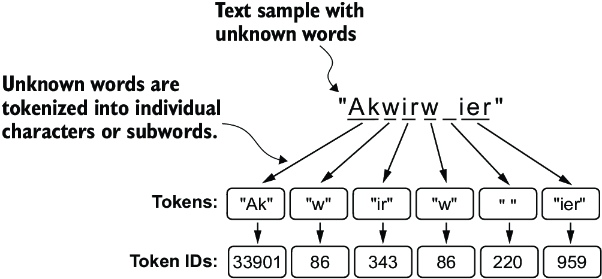

In [ ]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00


In [ ]:
from importlib.metadata import version
import tiktoken
print("tiktoken version: ", version("tiktoken"))

tiktoken version:  0.9.0


In [ ]:
BPE_tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
tokens = BPE_tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(tokens)



[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [ ]:
decode_text = BPE_tokenizer.decode(tokens)
print(decode_text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [ ]:
unknow_word = "Akwirw ier"
encode_nums = BPE_tokenizer.encode(unknow_word)
for num in encode_nums:
    print(f"{num}: {BPE_tokenizer.decode([num])}")

33901: Ak
86: w
343: ir
86: w
220:  
959: ier


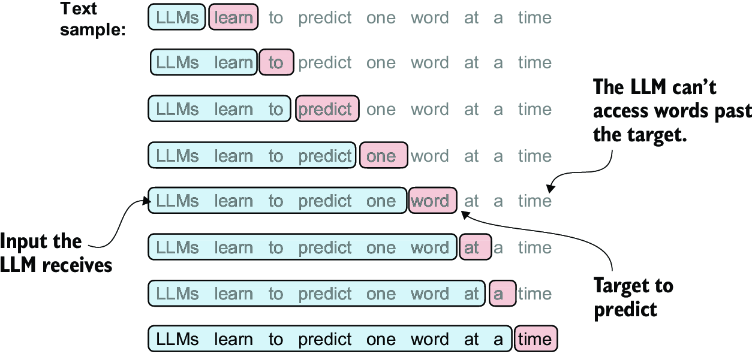

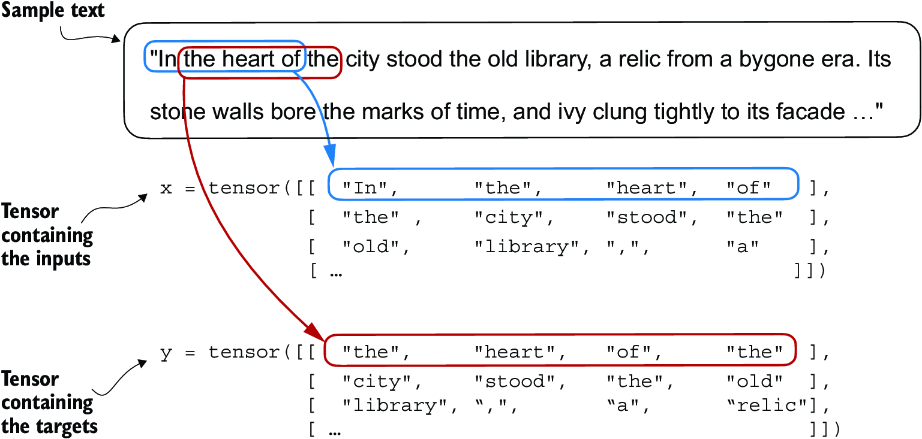

In [ ]:
import torch
from torch.utils.data import DataLoader,Dataset


In [ ]:
class GPTdatasetV1(Dataset):

    """
    Dataset for GPT-2, Slide Window.
    txt: Input text.
    tokenizer: Tokenizer.
    window_length: Length of the window.
    stride: Stride of the window. (How many words to skip).

    __len__: return size of the input data.
    """

    def __init__(self, txt, tokenizer, window_length, stride):
        self.input_ids = []
        self.output_ids = []

        words_to_nums = tokenizer.encode(txt)

        for i in range(0, len(words_to_nums) - window_length, stride):
            self.input_ids.append(torch.tensor(words_to_nums[i:i+window_length]))
            self.output_ids.append(torch.tensor(words_to_nums[i+1:i+window_length+1]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]


In [ ]:
# Customize dataloader

def create_dataloader_v1(txt, batch_size=4, window_length=256, stride=128,shuffle=True, drop_last=True, num_workers=0):
    # define tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # define dataset
    dataset = GPTdatasetV1(txt, tokenizer, window_length, stride)

    # define dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [ ]:
with open("the-verdict.txt", "r") as fn:
    raw_txt = fn.read()

dataloader = create_dataloader_v1(raw_txt, 1, 4, 1, False)
iter_dataloader = iter(dataloader)
first = next(iter_dataloader)
first

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]

## Token Embedding

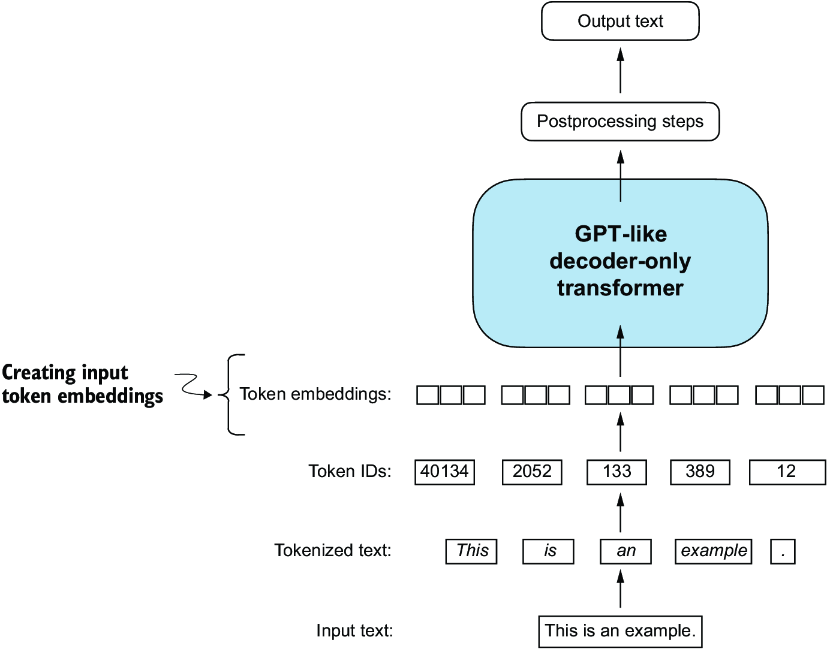

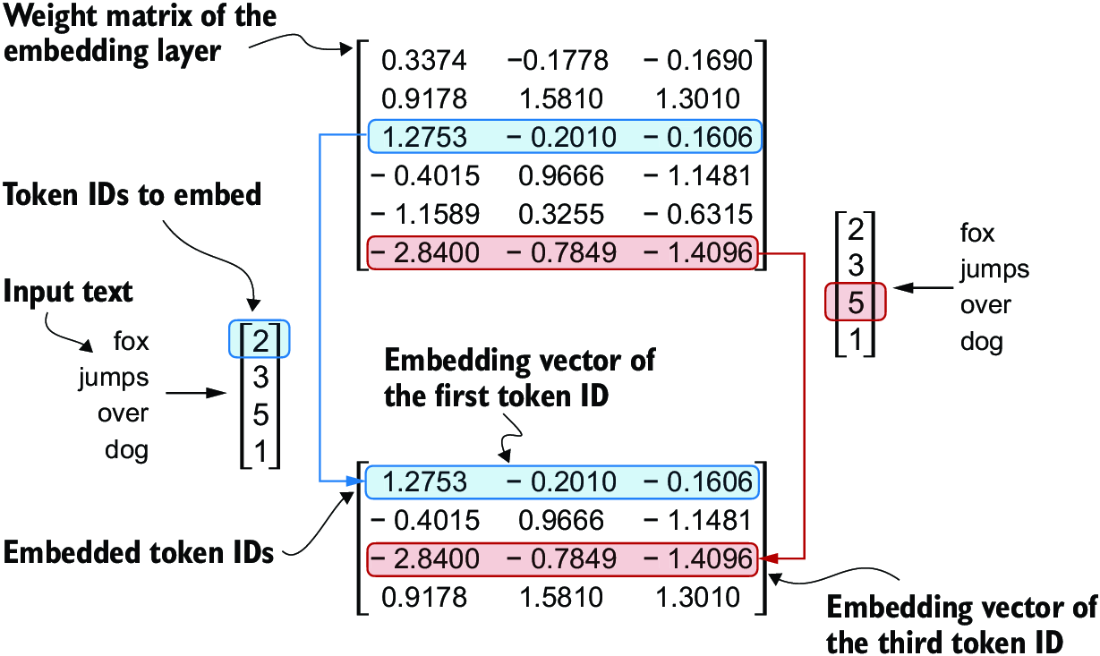

##Encoding word positions

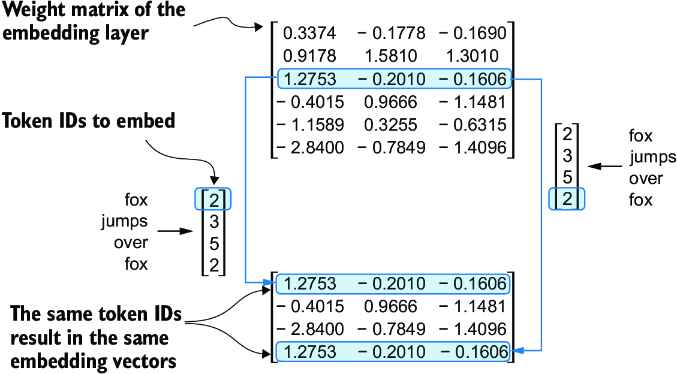

The way the previously introduced embedding layer works is that the same token ID always gets mapped to the same vector representation, regardless of where the token ID is positioned in the input sequence.The embedding layer converts a token ID into the same vector representation regardless of where it is located in the input sequence. For example, the token ID 5, whether it’s in the first or fourth position in the token ID input vector, will result in the same embedding vector.

since the self-attention mechanism of LLMs itself is also position-agnostic, it is helpful to inject additional position information into the LLM.

##Absolute positional embeddings

are directly associated with specific positions in a sequence. For each position in the input sequence, a unique embedding is added to the token’s embedding to convey its exact location. For instance, the first token will have a specific positional embedding, the second token another distinct embedding, and so on.

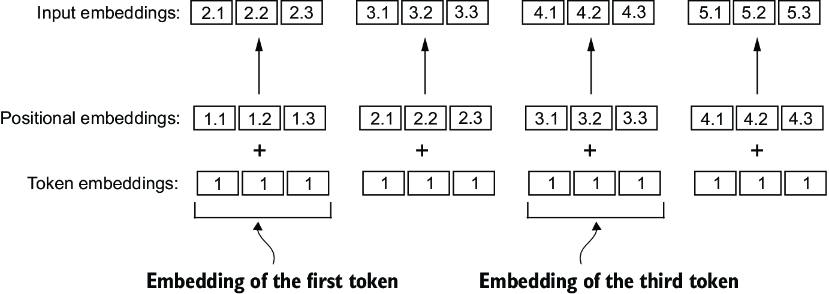

Positional embeddings are added to the token embedding vector to create the input embeddings for an LLM. The positional vectors have the same dimension as the original token embeddings. The token embeddings are shown with value 1 for simplicity.

## Relative positional embeddings

is on the relative position or distance between tokens. This means the model learns the relationships in terms of “how far apart” rather than “at which exact position.” The advantage here is that the model can generalize better to sequences of varying lengths, even if it hasn’t seen such lengths during training.

In [ ]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
token_embedding_layer

Embedding(50257, 256)

In [ ]:
# Batch size of 8 with 4 tokens each, 8 * 4 * 256

window_length = 4
dataloader = create_dataloader_v1(raw_text, 8, window_length, window_length, shuffle=False)
dataloader_iter = iter(dataloader)
inputs, outputs = next(dataloader_iter)
inputs.shape
# 8 words input , 4 for each word

torch.Size([8, 4])

In [ ]:
token_embedding = token_embedding_layer(inputs)
token_embedding.shape

torch.Size([8, 4, 256])

In [ ]:
# words
#-> create a Class  (tensor dataset) return [1. input words ids, 2. predict the next words ids] with encoder your choosed
#-> create dataloader with tiktoken encoder.return a tensor dataloader, [input, output(predict next word id)]
#-> use torch.nn.Embedding(datasize, output_dim) create a position matrix
#-> take the input from tensor dataloader apply to position matrix

For a GPT model’s absolute embedding approach, we just need to create another embedding layer that has the same embedding dimension as the token_embedding_ layer:

In [ ]:
context_length = max_length = 4
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)
pos_embeddings
# Note: layer is changeable even adopted to other layers
# pos_embedding_layer [changeable] -> torch.arange layer [static]

torch.Size([4, 256])


tensor([[-0.7649,  0.8062, -0.2066,  ...,  0.8718,  0.7964,  0.2901],
        [ 0.5224,  0.7117,  0.4916,  ...,  1.2320, -0.1112, -0.9641],
        [-1.3046,  1.2297,  1.5682,  ...,  0.3731,  0.1461,  1.3180],
        [-0.2516, -1.2492, -0.5614,  ..., -2.7251, -0.3023,  0.5992]],
       grad_fn=<EmbeddingBackward0>)

**torch.nn.Embedding(context_length, output_dim)**

Creates a learnable lookup table (i.e. embedding matrix) of shape [context_length, output_dim].

Each index i from 0 to context_length - 1 maps to a vector of size output_dim.

**torch.arange(context_length)**

Generates the sequence [0, 1, 2, ..., context_length - 1]. These are the absolute positions in the input sequence.

**pos_embedding_layer(...)**

Looks up the embedding for each absolute position index.

So position 0 always maps to the same vector, position 1 to another, and so on.

Result shape: [context_length, output_dim]

One embedding vector per absolute position.

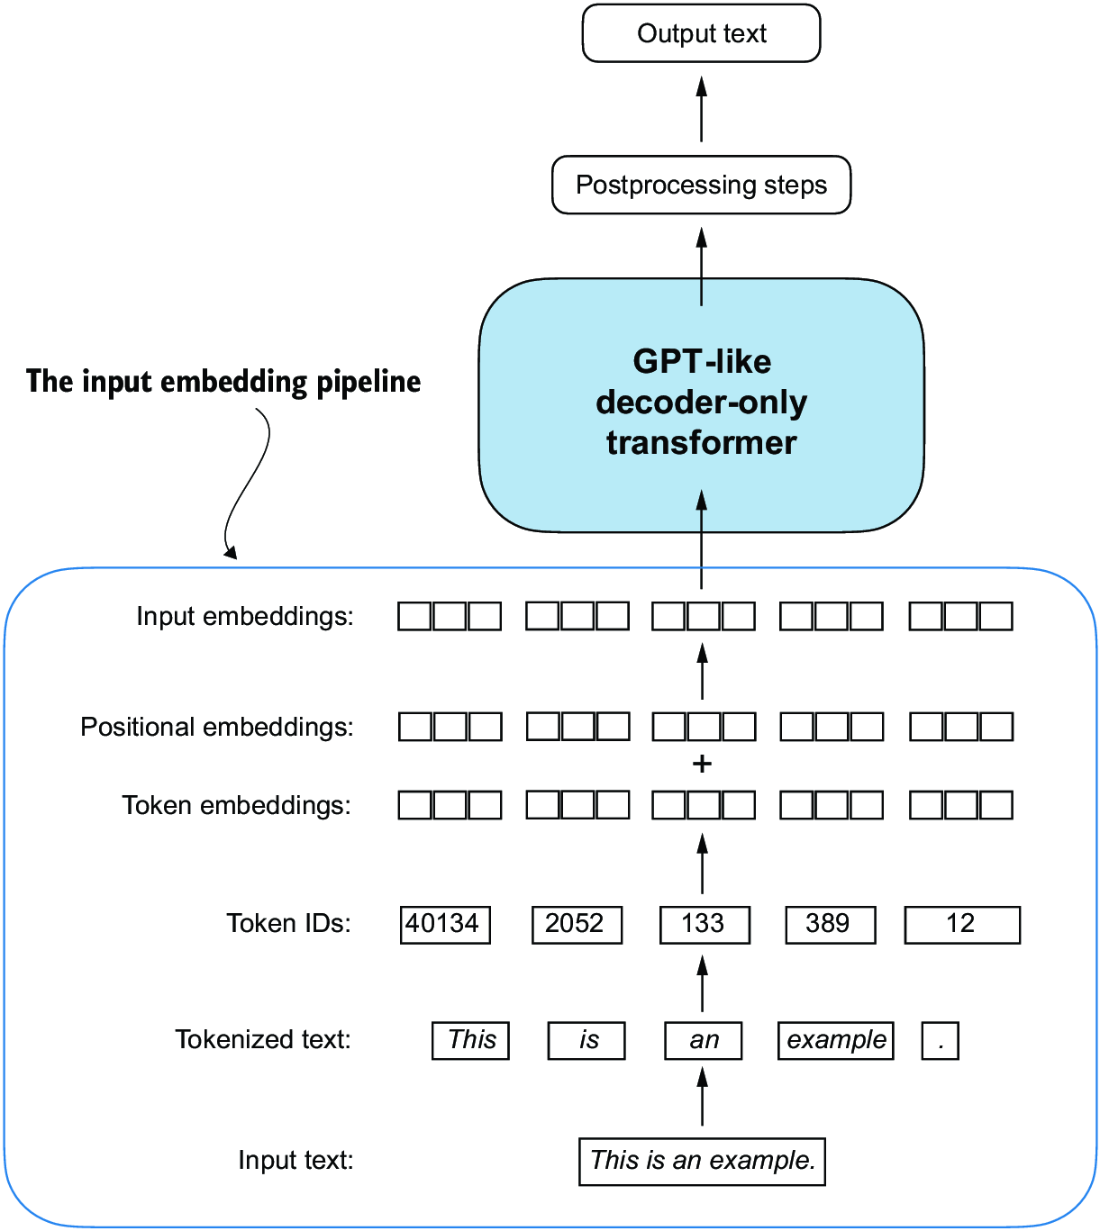

## SUMMARY

1. Raw text is broken into tokens, [words or charactors]
2. Tokens into integers -- token IDs
3. Handle special tokens: <|unk|> and <|endoftext|>
4. => BPE tokenizer -- tiktoken.get_encoding("gpt2")
5. Sliding window approach on tokenized data, input <-> predicted next word
6. Embedding layers in PyTorch function as a lookup operation, retrieving vectors corresponding to token IDs.
7. OpenAI’s GPT models utilize absolute positional embeddings, which are added to the token embedding vectors and are optimized during the model training.

## Start Token Embedding

In [ ]:
pip install tiktoken

In [ ]:
# 4. => BPE tokenizer -- tiktoken.get_encoding("gpt2")
import tiktoken
raw_text = "At this point, you know how to prepare the input text for training LLMs by splitting text into individual word and subword tokens, which can be encoded into vector representations, embeddings, for the LLM."
BPE_tokenizer_v1 = tiktoken.get_encoding("gpt2")
txt_encoding = BPE_tokenizer_v1.encode(raw_text)
txt_encoding[:5]

[2953, 428, 966, 11, 345]

In [ ]:
#5. Sliding window approach on tokenized data, input <-> predicted next word

import torch
from torch.utils.data import Dataset, DataLoader

class GPT_Dataset(Dataset):
  def __init__(self, txt, tokenizer, window_size, steps):
    self.input_ids = []
    self.output_ids = []

    word_nums = tokenizer.encode(txt)
    for i in range(0, len(word_nums) - window_size, steps):
      tensor_input = torch.tensor(word_nums[i : i + window_size])
      tensor_output = torch.tensor(word_nums[i + 1 : i + window_size + 1])
      self.input_ids.append(tensor_input)
      self.output_ids.append(tensor_output)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.output_ids[idx]



In [ ]:
#Embedding layers in PyTorch function as a lookup operation, retrieving vectors corresponding to token IDs
def customize_dataloader(txt, batch_size=4, window_size=256, steps=128, shuffle=True, drop_last=True, num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPT_Dataset(txt, tokenizer, window_size, steps)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
  return dataloader

with open("the-verdict.txt", "r") as fn:
    raw_txt = fn.read()

window_size = 4
dataloader = customize_dataloader(raw_text, 8, window_size, window_size, shuffle=False)
inputs, outputs = next(iter(dataloader))
inputs.shape


torch.Size([8, 4])

In [ ]:
# OpenAI’s GPT models utilize absolute positional embeddings, which are added to the token embedding vectors and are optimized during the model training.

input_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(input_size, output_dim)
token_embedding = token_embedding_layer(inputs)
token_embedding.shape

torch.Size([8, 4, 256])

## Start Positional Embeddings

In [ ]:
context_length = windew_size = 4
position_embedding_layer = torch.nn.Embedding(context_length, output_dim)
position_embedding = position_embedding_layer(torch.arange(context_length))
position_embedding.shape

torch.Size([4, 256])

## Start Input Embedding

In [ ]:
input_embedding = token_embedding + position_embedding
input_embedding.shape

torch.Size([8, 4, 256])

# CHAPTER 3

## The reasons for using attention mechanisms in neural networks



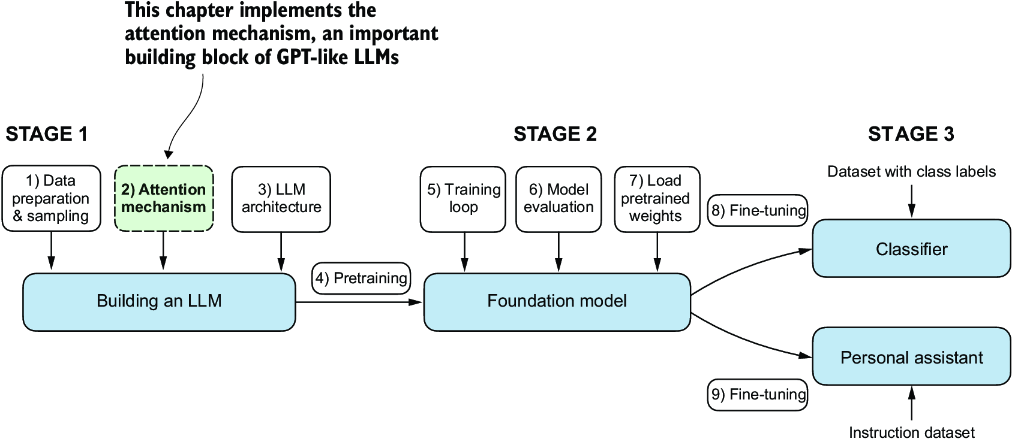


We will implement 4 different variants of attention machanism, These different attention variants build on each other. The goal is to arrive at a compact and efficient implementation fo multi-head attention that we can plug into the LLM.

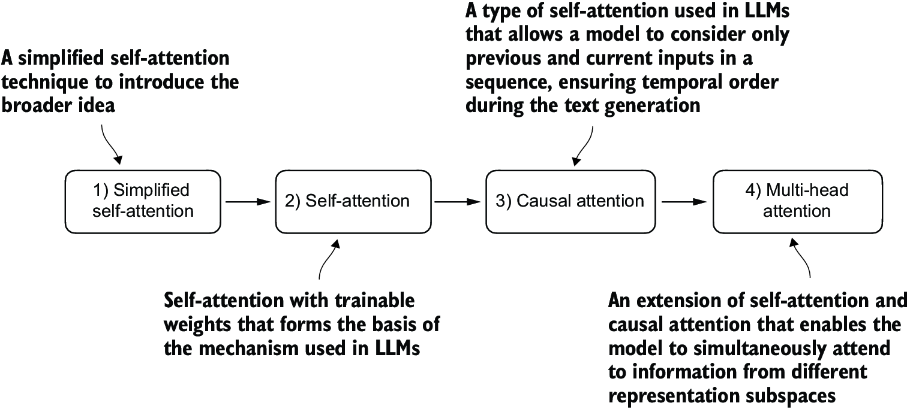

### 3.1 The problem with modeling long sequence

it’s not possible to merely translate word by word. Instead, the translation process requires contextual understanding and grammatical alignment.
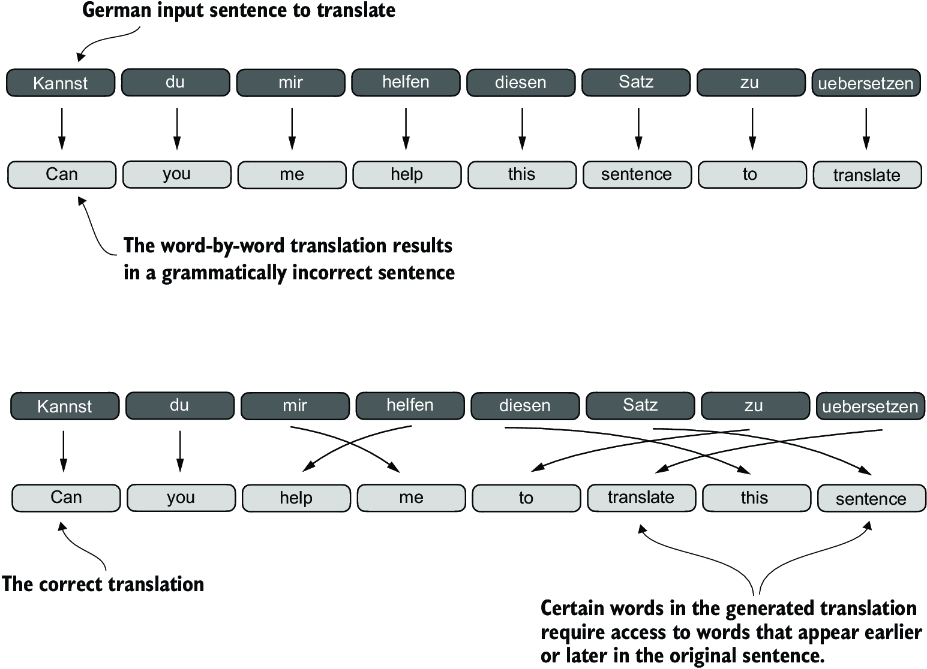

To address this problem, it is common to use a deep neural network with two submodules, an encoder and a decoder.

********

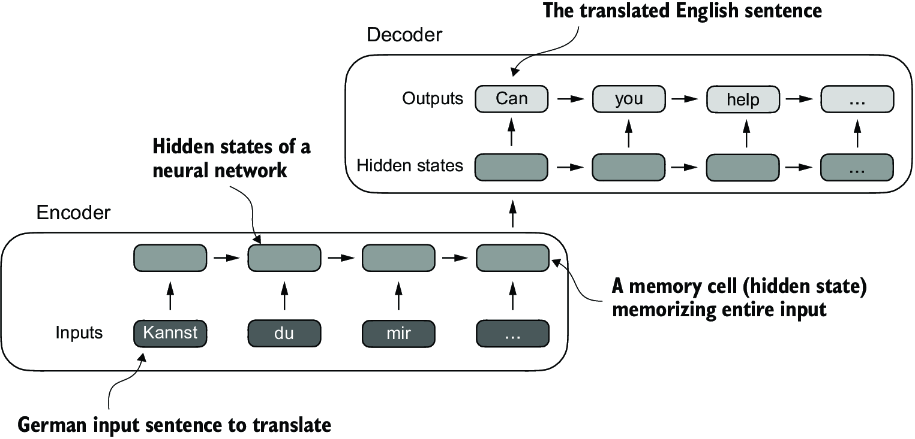

Before the advent of transformer models, encoder–decoder RNNs were a popular choice for machine translation. The encoder takes a sequence of tokens from the source language as input, where a hidden state (an intermediate neural network layer) of the encoder encodes a compressed representation of the entire input sequence. Then, the decoder uses its current hidden state to begin the translation, token by token.


**The big limitation of encoder–decoder RNNs is that the RNN can’t directly access earlier hidden states from the encoder during the decoding phase. Consequently, it relies solely on the current hidden state, which encapsulates all relevant information. This can lead to a loss of context, especially in complex sentences where dependencies might span long distances.**

### 3.2 Cpaturing data dependencies with attention mechanisms

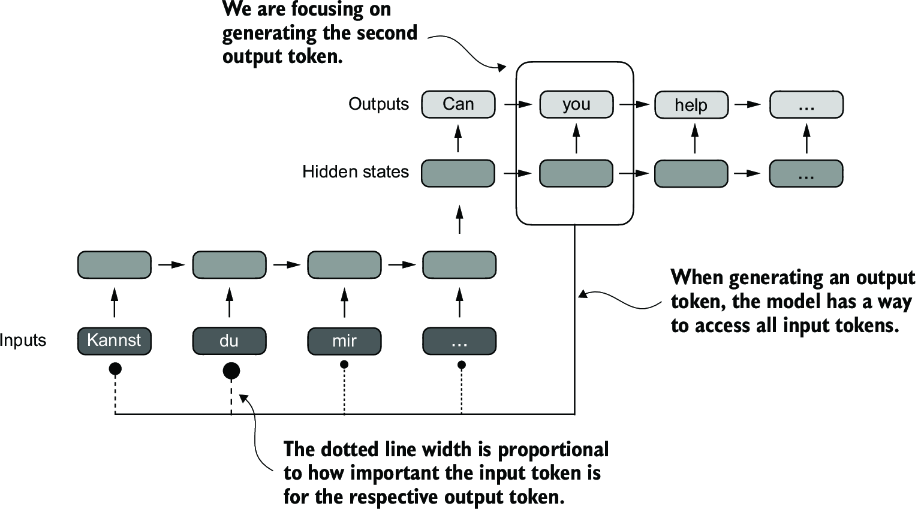
Using an attention mechanism, the text-generating decoder part of the network can access all input tokens selectively. This means that some input tokens are more important than others for generating a given output token. The importance is determined by the attention weights

only three years later, researchers found that RNN architectures are not required for building deep neural networks for natural language processing and proposed the original transformer architecture.

Self-attention is a mechanism that allows each position in the input sequence to consider the relevancy of, or “attend to,” all other positions in the same sequence when computing the representation of a sequence. Self-attention is a **key component** of contemporary LLMs based on the transformer architecture, such as the GPT series.

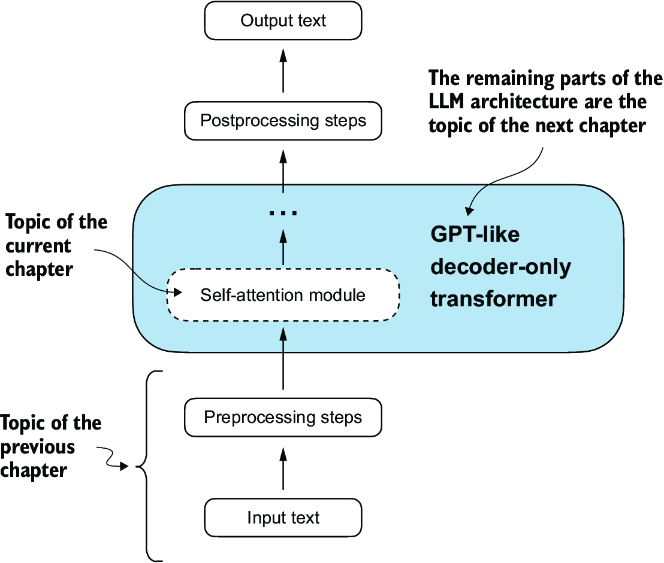

Self-attention is a mechanism in transformers used to compute more efficient input representations by allowing each position in a sequence to interact with and weight the importance of all other positions within the same sequence.

### 3.3 Attending to different parts of the input with self-attention.

The *“self”* refers to the mechanism’s ability to compute attention **weights** by relating different **positions** within a single input sequence.

#### 3.3.1 A simple self-attention mechanism without trainable weights

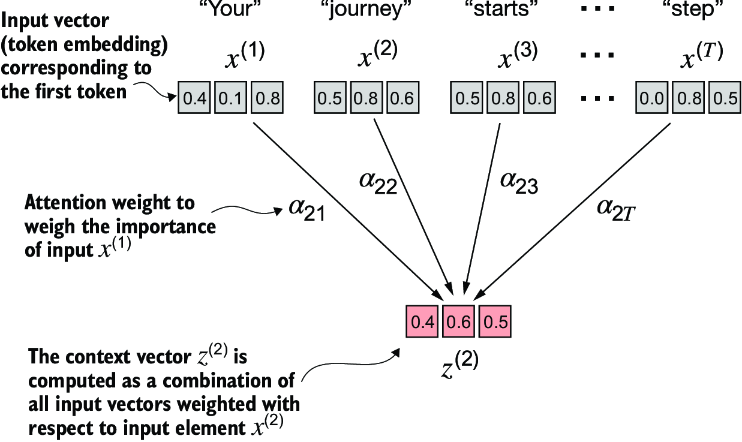

The goal of self-attention is to compute a context vector for each input element that combines information from all other input elements. In this example, we compute the context vector z(2). The importance or contribution of each input element for computing z(2) is determined by the attention weights a21 to a2T. When computing z(2), the attention weights are calculated with respect to input element x(2) and all other inputs.

> *Context vectors* play a crucial role in self-attention. Their purpose is to create enriched representations of each element in an input sequence (like a sentence) by incorporating information from all other elements in the sequence


In [ ]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

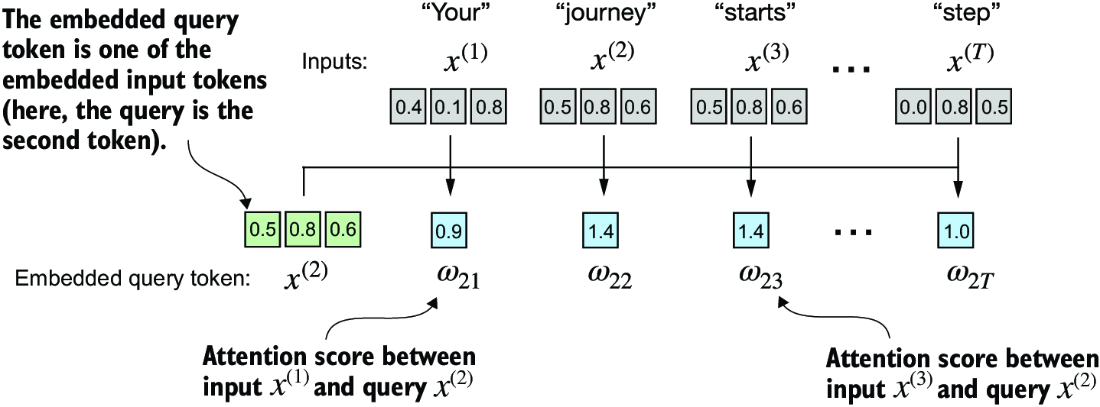

* 1. The first step: Compute the intermediate values w (Attention scores)
> *Why we not use the token embedding?* <br>
> 0.87 is truncated to 0.8. In this truncated version, the embeddings of the words “journey” and “starts” may appear similar by random chance.

In [ ]:
# calculate the intermediate attention scores between the query token and each input token.
# We determine these scores by computing the dot product of the query, x(2), with every other input token:

second_word_query_token = inputs[1] # the second word's token
attention_score_to_second_word = torch.empty(inputs.shape[0]) # same shape with the first dim [6] of inputs [6, 3] but with uninitialized data
for num_index, matrix in enumerate(inputs):
  attention_score_to_second_word[num_index] = torch.dot(matrix, second_word_query_token)

attention_score_to_second_word

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

> the dot product is a measure of similarity because it quantifies ***how closely two vectors are aligned***: a higher dot product indicates a greater degree of alignment or similarity between the vectors. In the context of self-attention mechanisms, the dot product determines the extent to which each element in a sequence focuses on, or “attends to,” any other element: the higher the dot product, the higher the similarity and attention score between two elements.

* 2. The second step: Nomalize the weights. This normalization is a convvention that is useful for interpretation and maintaining training stability in an LLM.

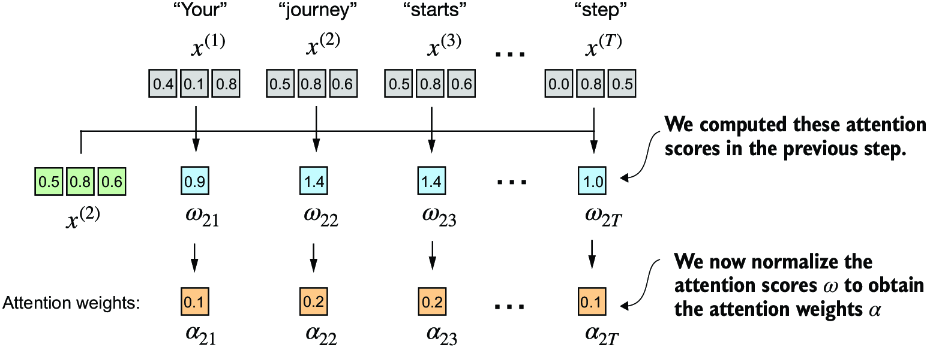

In [ ]:
sum_of_weights = attention_score_to_second_word.sum()
normalize_weights = attention_score_to_second_word / sum_of_weights
normalize_weights

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

> In practice, It's more common and advisable to use the *Softmax* function for normalization. In addition, the Softmax function always ensure the weights are positive. This makes output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

In [ ]:
# Attention weights respect to input 2

normalize_fn = torch.nn.Softmax(dim=0)
# or
softmax_result = torch.softmax(attention_score_to_second_word, dim=-1)
softmax_result

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

> The results are bit difference.
> 1.   tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
> 2.   tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
> ***
> It becauses the Softmax takes exponation of each value.
> Softmax = exp(tensor_i) / sum (exp (tensor))
> Make difference more obviously.


* 3. Calculating the context vector z(2) by **multiplying** the embedded input tokens x(i), with the corresponding weights and then **summing** the resulting vecetors.

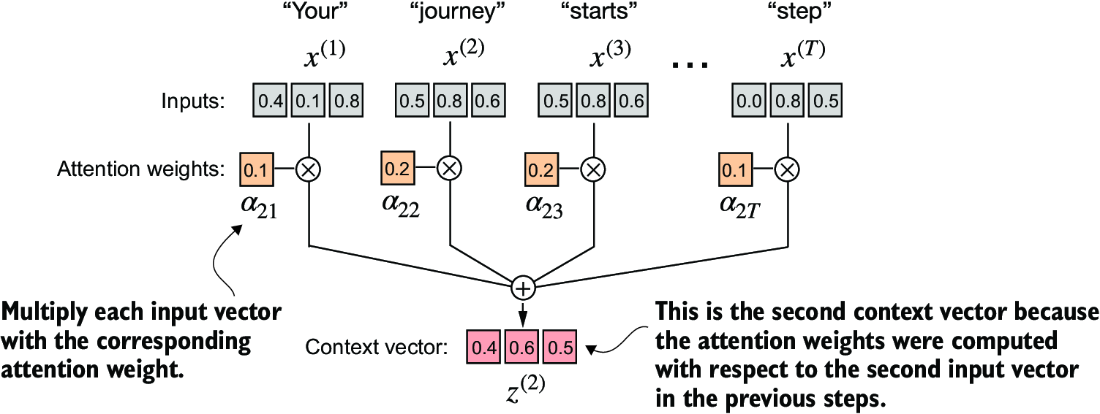

In [ ]:
# Context vector for input 2
# the context vector should have same shape with the query's shape.
#从inputs encoded 变成 context vector, 目的是通过dim不变的情况下,让所有的vector之间通过weights产生连接.
query = inputs[1]

context_vector_v2 = torch.zeros(query.shape)
for idx, matrix in enumerate(inputs):
  context_vector_v2 += matrix * softmax_result[idx]

context_vector_v2

tensor([0.4419, 0.6515, 0.5683])

#### 3.3.2 Computing attention weights for all input tokens

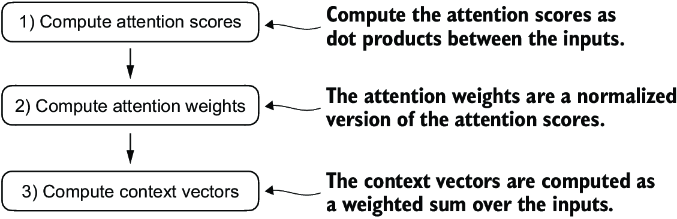

> COMPUTE ATTENTION SCORES。=> matrix @ matrix.T

Step 1, Token embedding for each of them.

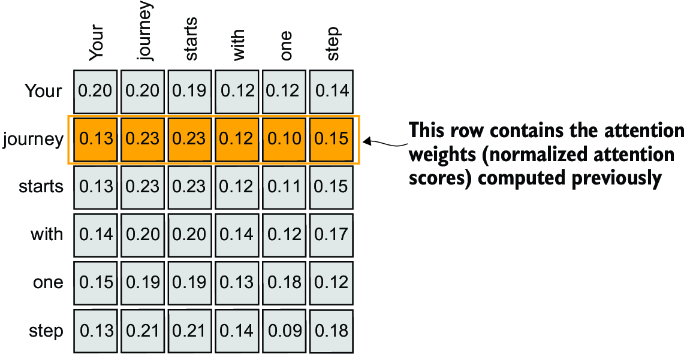

In [ ]:
# Dot product for each 1-1 2-1 3-1 ...2-1 2-2 3-2...6-6

len_words = inputs.shape[0]
attention_score_matrix = torch.empty(len_words, len_words)
for row_index, row_value in enumerate(inputs):
  for col_index, cal_value in enumerate(inputs):
    attention_score_matrix[row_index, col_index] = torch.dot(row_value, cal_value)

attention_score_matrix

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

⏬

In [ ]:
# Faster process for Dot product
# matrix @ matrix.T
attention_score_matrix = inputs @ inputs.T
attention_score_matrix

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [ ]:
normalize_weights = torch.softmax(attention_score_matrix, dim=-1)
normalize_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

> Step 3: Use attention weights to compute all context vectors.
> weights martix @ original matrix

In [ ]:
all_context_vectors = normalize_weights @ inputs
all_context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])